## Imports

In [1]:
%matplotlib inline

import json
import os
import glob
import boto3

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

## Downloading data from S3

In [2]:
client = boto3.client('s3',
                     aws_access_key_id = os.getenv('aws_access_key'),
                     aws_secret_access_key = os.getenv('aws_secret_key'),
                     )

In [3]:
bucket_list = client.list_buckets()

In [4]:
bucket_name = 'summit-demo'

In [5]:
object_list = client.list_objects_v2(Bucket = bucket_name)['Contents']

In [6]:
len(object_list)

1000

In [7]:
paginator = client.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix='ai-sensor-v3/device')

key_list = []
for p in pages:
    for o in p['Contents']:
        key_list.append(o['Key'])

In [8]:
print(key_list[0:10])

['ai-sensor-v3/device01/2022-02-28T16:06:33.752829.json', 'ai-sensor-v3/device01/2022-02-28T16:06:33.753092.json', 'ai-sensor-v3/device01/2022-02-28T16:06:33.754278.json', 'ai-sensor-v3/device01/2022-02-28T16:06:33.754584.json', 'ai-sensor-v3/device01/2022-02-28T16:06:34.490625.json', 'ai-sensor-v3/device01/2022-02-28T16:06:34.492986.json', 'ai-sensor-v3/device01/2022-02-28T16:06:35.315408.json', 'ai-sensor-v3/device01/2022-02-28T16:06:36.039800.json', 'ai-sensor-v3/device01/2022-02-28T16:06:37.446556.json', 'ai-sensor-v3/device01/2022-02-28T16:06:37.496693.json']


In [9]:
len(key_list)

1658

### WARNING: This will start downloading data

In [10]:
data_list = []
for k in key_list:
    data = client.get_object(Bucket = bucket_name, Key = k)['Body'].readlines()
    data_list.append(data)

## Data Exploration and Plotting

In [12]:
print(f'Example data: {type(data_list[0][0])} \n {data_list[0][0]}')
data = [json.loads(d[0].decode('utf-8')) for d in data_list]
print(f'\nDecoded data: {type(data[0])}\n {data[0]}')
print(f'\nDecode data: {data[0]["data"]}')

Example data: <class 'bytes'> 
 b'{"specversion":"1.0","id":"9908c9cb-2658-44b1-9123-a0f84bf26597","type":"io.drogue.event.v1","source":"drogue://burrboard/device01","datacontenttype":"application/json","subject":"state","time":"2022-02-28T16:06:33.741695136Z","data":{"features":{"led_1":{"state":false}}},"applicationuid":"6336013e-75d0-4457-b941-8ba63f5f0597","deviceuid":"c0108d44-8980-44f8-8201-46681179b184","senderuid":"c0108d44-8980-44f8-8201-46681179b184","sender":"device01","application":"burrboard","device":"device01","instance":"drogue","partitionkey":"burrboard/device01"}'

Decoded data: <class 'dict'>
 {'specversion': '1.0', 'id': '9908c9cb-2658-44b1-9123-a0f84bf26597', 'type': 'io.drogue.event.v1', 'source': 'drogue://burrboard/device01', 'datacontenttype': 'application/json', 'subject': 'state', 'time': '2022-02-28T16:06:33.741695136Z', 'data': {'features': {'led_1': {'state': False}}}, 'applicationuid': '6336013e-75d0-4457-b941-8ba63f5f0597', 'deviceuid': 'c0108d44-8980-44

In [13]:
uniq_dids = np.unique([d['deviceuid'] for d in data])
print(f'Number of unique devices: {len(uniq_dids)}')

Number of unique devices: 5


In [14]:
#number of features
#[d['data'] for d in data if len(d['data']['features'])>1] 
print('Each data packet can consist of one or multiple metrics collected at particular timestamp')
print(f'Distribution of number of metrics')
n_metrics, n_counts = np.unique([len(d['data']['features']) for d in data], return_counts=True)
for idx in range(len(n_metrics)):
    print(f'\t{n_counts[idx]} data packets/timestamps have {n_metrics[idx]} metrics/features')

Each data packet can consist of one or multiple metrics collected at particular timestamp
Distribution of number of metrics
	196 data packets/timestamps have 1 metrics/features
	1035 data packets/timestamps have 8 metrics/features
	427 data packets/timestamps have 10 metrics/features


In [15]:
#unique features
uniq_features = np.unique(np.concatenate([list(d['data']['features'].keys()) for d in data]))
print('Metrics/features collected:')
for f in uniq_features: print('\t', f)

Metrics/features collected:
	 accelerometer
	 button_a
	 button_b
	 device
	 led_1
	 led_2
	 led_3
	 led_4
	 light
	 temperature


In [16]:
uniq_features

array(['accelerometer', 'button_a', 'button_b', 'device', 'led_1',
       'led_2', 'led_3', 'led_4', 'light', 'temperature'], dtype='<U13')

In [19]:
data[0]

{'specversion': '1.0',
 'id': '9908c9cb-2658-44b1-9123-a0f84bf26597',
 'type': 'io.drogue.event.v1',
 'source': 'drogue://burrboard/device01',
 'datacontenttype': 'application/json',
 'subject': 'state',
 'time': '2022-02-28T16:06:33.741695136Z',
 'data': {'features': {'led_1': {'state': False}}},
 'applicationuid': '6336013e-75d0-4457-b941-8ba63f5f0597',
 'deviceuid': 'c0108d44-8980-44f8-8201-46681179b184',
 'senderuid': 'c0108d44-8980-44f8-8201-46681179b184',
 'sender': 'device01',
 'application': 'burrboard',
 'device': 'device01',
 'instance': 'drogue',
 'partitionkey': 'burrboard/device01'}

In [23]:
fields = {}
for d in data:
    for f in d['data']['features']:
        if f not in fields:
            fields[f] = []
        for k in d['data']['features'][f].keys():
            if k not in fields[f]:
                fields[f].append(k)

print('Fields available for metrics:')
for k in fields:
    print('\t', k, fields[k])

Fields available for metrics:
	 led_1 ['state']
	 temperature ['value']
	 led_3 ['state']
	 led_2 ['state']
	 light ['value']
	 led_4 ['state']
	 button_a ['presses']
	 button_b ['presses']
	 accelerometer ['x', 'y', 'z']
	 device ['battery']


In [9]:
#format data by device ids ("did")
data_ts = {}
for i in uniq_dids: 
    data_ts[i] = [(d['time'], d['data']) for d in data if d['deviceuid']==i]
    
data_df = {'deviceuid': [], 'timestamp': [], 'metric': [], 'key': [], 'val': []}
for d in data: #(ts, uid)
    for m in d['data']['features']: #light, temp, accelerometer etc.
        if m=='accelerometer':
            data_df['deviceuid'].append(d['deviceuid'])
            data_df['timestamp'].append(d['time'])
    
            data_df['metric'].append(m)
            data_df['key'].append('mag')
            
            mag = np.sqrt(d['data']['features'][m]['x']**2 + d['data']['features'][m]['y']**2 + d['data']['features'][m]['z']**2)
            data_df['val'].append(mag)
            
        for v in d['data']['features'][m]: #1 val or 3 vals (acc) 
            
            data_df['deviceuid'].append(d['deviceuid'])
            data_df['timestamp'].append(d['time'])
    
            data_df['metric'].append(m)
            data_df['key'].append(v)
            data_df['val'].append(d['data']['features'][m][v])
            
data_df_flat = {'deviceuid': [], 'timestamp': []}
for f in fields:
    for k in fields[f]:
        data_df_flat[f'{f}_{k}'] = []

for d in data:
    data_df_flat['deviceuid'].append(d['deviceuid'])
    data_df_flat['timestamp'].append(d['time'])
    
    for f in uniq_features:
        for k in fields[f]:
            colname = f'{f}_{k}'            
            try:
                data_df_flat[colname].append(d['data']['features'][f][k])
            except:
                data_df_flat[colname].append(np.nan)

NameError: name 'uniq_dids' is not defined

In [54]:
df = pd.DataFrame(data_df)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['deviceuid', 'timestamp', 'metric'], inplace=True)
df.to_csv('data.csv', index=False)

df_flat = pd.DataFrame(data_df_flat)
df_flat['timestamp'] = pd.to_datetime(df_flat['timestamp'])
df_flat.sort_values(by=['deviceuid', 'timestamp'], inplace=True)
if 'accelerometer_x' in df_flat:
    df_flat['accelerometer_mag'] = np.sqrt(df_flat['accelerometer_x'].fillna(0)**2 + df_flat['accelerometer_y'].fillna(0)**2 + df_flat['accelerometer_z'].fillna(0)**2)
df_flat.to_csv('data_flat.csv', index=False)

In [55]:
df.head()

,deviceuid,timestamp,metric,key,val
13079,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.133909687+00:00,led_1,state,False
13078,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134118885+00:00,led_2,state,False
13077,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134351977+00:00,led_3,state,False
13080,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134526240+00:00,led_4,state,False
13076,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134705075+00:00,temperature,value,29.6


In [56]:
df_flat.head()

,deviceuid,timestamp,led_1_state,temperature_value,led_3_state,led_2_state,light_value,led_4_state,button_a_presses,button_b_presses,accelerometer_x,accelerometer_y,accelerometer_z,device_battery,accelerometer_mag
1396,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.133909687+00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1395,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134118885+00:00,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1394,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134351977+00:00,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1397,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134526240+00:00,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1393,1ba1ce6a-72a3-4372-bbea-afd966ad2767,2022-03-02 15:43:48.134705075+00:00,NaN,29.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


<Figure size 1080x1080 with 0 Axes>

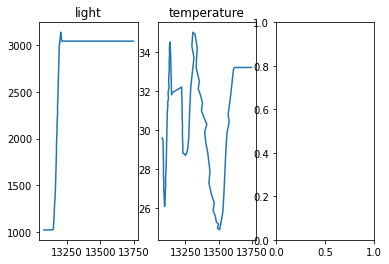

<Figure size 1080x1080 with 0 Axes>

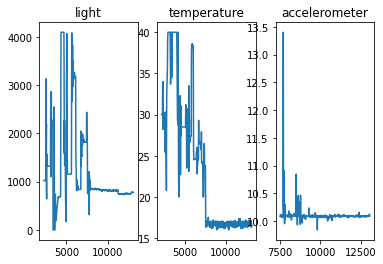

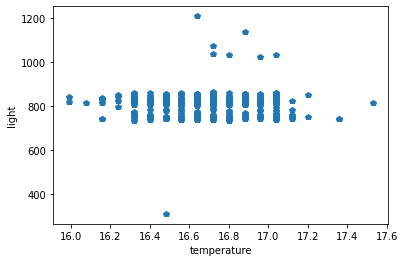

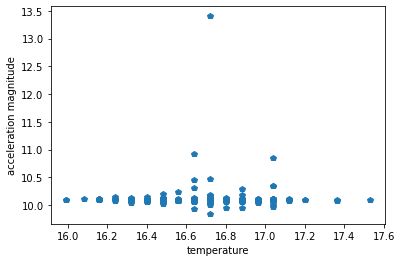

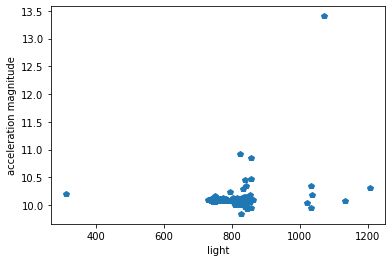

<Figure size 1080x1080 with 0 Axes>

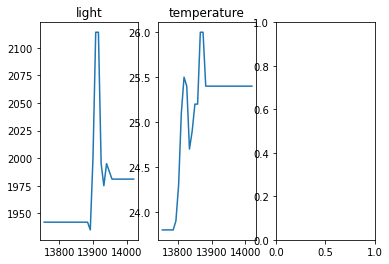

<Figure size 1080x1080 with 0 Axes>

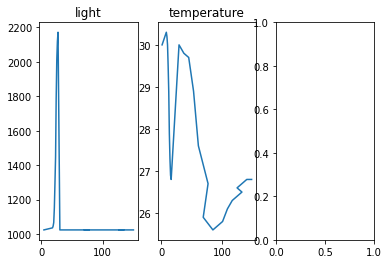

<Figure size 1080x1080 with 0 Axes>

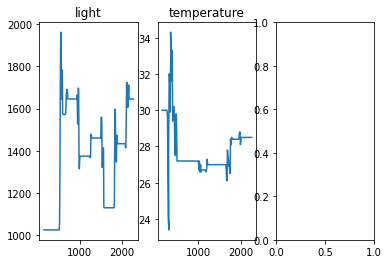

In [67]:
features = ['light', 'temperature', 'accelerometer']

for did in uniq_dids:
    plt.figure(figsize=(15,15))
    fig, ax = plt.subplots(nrows=1, ncols=len(features))
    
    for idx, m in enumerate(features):
        #plt.subplot(f'{len(features)}1{idx+1}')
        
        if m=='accelerometer':
            filtered = df[(df['deviceuid']==did) & (df['metric']==m) & (df['key']=='mag')]['val']
        else:
            filtered = df[(df['deviceuid']==did) & (df['metric']==m)]['val']
            
        if filtered.shape[0] > 0:
            ax[idx].plot(filtered)
            ax[idx].set_title(m)
        
    temp_df = df_flat[(df_flat['deviceuid']==did)].dropna().sort_values(by='timestamp')        
    if temp_df.shape[0] > 0:
        _ = plt.figure()
        plt.plot(temp_df['temperature_value'], temp_df['light_value'], 'p')
        plt.xlabel('temperature')
        plt.ylabel('light')

        _ = plt.figure()
        plt.plot(temp_df['temperature_value'], temp_df['accelerometer_mag'], 'p')
        plt.xlabel('temperature')
        plt.ylabel('acceleration magnitude')

        _ = plt.figure()
        plt.plot(temp_df['light_value'], temp_df['accelerometer_mag'], 'p')
        plt.xlabel('light')
        plt.ylabel('acceleration magnitude')

## Write to file

In [12]:
%%writefile ../service/test/test.py

import json
import os
import glob
import boto3

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

def read_data(bucket_name='summit-demo', prefix='ai-sensor-v3/device', n_data_max=None):
    '''use s3 client to download data from bucket
    '''
    client = boto3.client('s3',
                     aws_access_key_id = os.getenv('aws_access_key'),
                     aws_secret_access_key = os.getenv('aws_secret_key'),
                     )

    bucket_list = client.list_buckets()

    object_list = client.list_objects_v2(Bucket = bucket_name)['Contents']

    paginator = client.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

    key_list = []
    for p in pages:
        for o in p['Contents']:
            key_list.append(o['Key'])

    print(f'Example keys:')
    for k in key_list[0:10]: print('\t', k)

    n_keys = len(key_list)
    data_list = []
    for idx, k in enumerate(key_list):
        if n_data_max is not None and idx >= n_data_max: break
            
        if idx % 100 == 0:
            print(f'Fetching key number {idx+1} of {n_keys}')
            
        data = client.get_object(Bucket = bucket_name, Key = k)['Body'].readlines()
        data_list.append(data)
    
    return data_list
    
def create_df(data_list, out_loc):
    '''create dataframes from raw data
    '''

    data = [json.loads(d[0].decode('utf-8')) for d in data_list] #decode dictionaries    
    
    uniq_dids = np.unique([d['deviceuid'] for d in data]) #unique device uids
    uniq_features = np.unique(np.concatenate([list(d['data']['features'].keys()) for d in data])) #unique feature names

    fields = {} #get mapping from field name -> dict key e.g. accelerometer -> ['x', 'y', 'z']
    for d in data:
        for f in d['data']['features']:
            if f not in fields:
                fields[f] = []
            for k in d['data']['features'][f].keys():
                if k not in fields[f]:
                    fields[f].append(k)

    #one row per device, timestamp, and metric
    data_df = {'deviceuid': [], 'timestamp': [], 'metric': [], 'key': [], 'val': []}
    for d in data: #(ts, uid)
        for m in d['data']['features']: #light, temp, accelerometer etc.
            if m=='accelerometer':
                data_df['deviceuid'].append(d['deviceuid'])
                data_df['timestamp'].append(d['time'])

                data_df['metric'].append(m)
                data_df['key'].append('mag')

                mag = np.sqrt(d['data']['features'][m]['x']**2 + d['data']['features'][m]['y']**2 + d['data']['features'][m]['z']**2)
                data_df['val'].append(mag)

            for v in d['data']['features'][m]: #1 val or 3 vals (acc) 

                data_df['deviceuid'].append(d['deviceuid'])
                data_df['timestamp'].append(d['time'])

                data_df['metric'].append(m)
                data_df['key'].append(v)
                data_df['val'].append(d['data']['features'][m][v])

    #one row per device, timestamp (metrics flattened into row)
    data_df_flat = {'deviceuid': [], 'timestamp': []}
    for f in fields:
        for k in fields[f]:
            data_df_flat[f'{f}_{k}'] = []

    for d in data:
        data_df_flat['deviceuid'].append(d['deviceuid'])
        data_df_flat['timestamp'].append(d['time'])

        for f in uniq_features:
            for k in fields[f]:
                colname = f'{f}_{k}'            
                try:
                    data_df_flat[colname].append(d['data']['features'][f][k])
                except:
                    data_df_flat[colname].append(np.nan)

    #create and save dataframes
    if not os.path.exists(out_loc):
        os.makedirs(out_loc)
    
    df = pd.DataFrame(data_df)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values(by=['deviceuid', 'timestamp', 'metric'], inplace=True)
    df.to_csv(f'{out_loc}/data.csv', index=False)

    df_flat = pd.DataFrame(data_df_flat)
    df_flat['timestamp'] = pd.to_datetime(df_flat['timestamp'])
    df_flat.sort_values(by=['deviceuid', 'timestamp'], inplace=True)
    df_flat['accelerometer_mag'] = df_flat[['accelerometer_x', 'accelerometer_y', 'accelerometer_z']].apply(lambda x: np.sqrt((x**2).sum()) if not x.isna().any() else np.nan, axis=1)

    df_flat.to_csv(f'{out_loc}/data_flat.csv', index=False)
    
    return df, df_flat, fields
    
def read_data_from_csv(out_loc):
    df = pd.read_csv(f'{out_loc}/data.csv')
    df_flat = pd.read_csv(f'{out_loc}/data_flat.csv')
    
    return df, df_flat
    
def plot_data(df, df_flat):
    features = ['light', 'temperature', 'accelerometer'] #should be in config

    uniq_dids = df['deviceuid'].unique()
    
    for did in uniq_dids:
        plt.figure(figsize=(15,15))
        fig, ax = plt.subplots(nrows=1, ncols=len(features))

        for idx, m in enumerate(features):
            #plt.subplot(f'{len(features)}1{idx+1}')

            if m=='accelerometer':
                filtered = df[(df['deviceuid']==did) & (df['metric']==m) & (df['key']=='mag')]['val']
            else:
                filtered = df[(df['deviceuid']==did) & (df['metric']==m)]['val']

            if filtered.shape[0] > 0:
                ax[idx].plot(filtered)
                ax[idx].set_title(m)

        temp_df = df_flat[(df_flat['deviceuid']==did)].dropna().sort_values(by='timestamp')        
        if temp_df.shape[0] > 0:
            _ = plt.figure()
            plt.plot(temp_df['temperature_value'], temp_df['light_value'], 'p')
            plt.xlabel('temperature')
            plt.ylabel('light')

            _ = plt.figure()
            plt.plot(temp_df['temperature_value'], temp_df['accelerometer_mag'], 'p')
            plt.xlabel('temperature')
            plt.ylabel('acceleration magnitude')

            _ = plt.figure()
            plt.plot(temp_df['light_value'], temp_df['accelerometer_mag'], 'p')
            plt.xlabel('light')
            plt.ylabel('acceleration magnitude')
    
def calibrate(df, df_flat, plot_loc):
    p_list = [10, 25, 50, 75, 90] #compute these percentiles. should be in config file
    low_p = 25
    high_p = 75
        
    if not os.path.exists(plot_loc):
        os.makedirs(plot_loc)

    uniq_dids = df['deviceuid'].unique()
    
    cals = {} #deviceuid -> feature name -> low, high

    for did in list(uniq_dids) + ['global']:
        if did == 'global':
            temp_df = df_flat.sort_values(by='timestamp')
        else:
            temp_df = df_flat[df_flat['deviceuid']==did].sort_values(by='timestamp')
        
        cals[did] = {}
        
        for k in temp_df.columns: #loop over each metric
            cals[did][k] = {}
            
            if k=='deviceuid' or k=='timestamp': #index columns
                continue 
            
            d = temp_df[k].copy()
            
            if d.dropna().shape[0] == 0: #don't have data
                cals[did][k]['low'] = cals[did][k]['high'] = None
                
            else: #have data                
                d = d.dropna()
    
                plt.figure()
                n,b,p = plt.hist(d, bins=10) #plot distribution of values
                plt.title(did)
                plt.xlabel(k)
                
                t = np.percentile(d, q=p_list)
                
                mapping = dict(zip(p_list, t))
                print(did, k, mapping)
                cals[did][k]['low'] = mapping[low_p]
                cals[did][k]['high'] = mapping[high_p]
    
                #plot percentiles on histogram
                for p in p_list:
                    plt.vlines(mapping[p], 0, n.max()*1.2, color='r', label=p)
                plt.savefig(f'{plot_loc}/{did}_{k}_hist.png')
                
                plt.figure()
                plt.plot(d.tolist(), 'p-')
                plt.xlabel('time')
                plt.ylabel(k)
                plt.title(did)

                plt.hlines(mapping[low_p], 0, d.shape[0], color='r')
                plt.hlines(mapping[high_p], 0, d.shape[0], color='r')    
                plt.savefig(f'{plot_loc}/{did}_{k}_ts.png')
    
    return cals

def write_json(cals, loc):
    json.dump(cals, open(loc, 'r'))

def read_json(loc):
    return json.load(open(loc, 'r'))

def predict(data, cals, fields):
    '''Input is data packet
    '''
    res = {}
    
    for f in data['features']: #'acc', 'led_1' etc.
        res = {}
        if f=='accelerometer':
            val = 0
            for k in fields[f]:
                val += data['features'][f][k]**2
            val = np.sqrt(val)

            k = 'mag'
            r = (val > cals[data['deviceuid']][f'{f}_{k}']['low']) and (val < cals[data['deviceuid']][f'{f}_{k}']['high'])
            
        else:
            for k in fields[f]:
                
                val = data['features'][f][k]
                
                r = (val > cals[data['deviceuid']][f'{f}_{k}']['low']) and (val < cals[data['deviceuid']][f'{f}_{k}']['high'])
                
                res[f'{f}_{k}'] = r
        
    return res

Overwriting ../service/test/test.py


# Synthetic data examples

In [ ]:
def gen_data(mean, std, N=1000):
    '''This is not representative of time-series
    data since all samples are generated independently
    i.e. no correlations but the goal is to show simple
    strategies for scoring so it's okay
    '''
    return np.random.normal(loc=mean, scale=std, size=N)

In [ ]:
N = 100

In [ ]:
acc_x = gen_data(1, 0.2, N)
acc_y = gen_data(1, 0.2, N)
acc_z = gen_data(1, 0.2, N)
light = gen_data(3, 2, N)
temp = gen_data(10, 1, N)

#### Note: no units assumed in the plots below i.e. these could be some uncalibrated measurements

In [ ]:
plt.figure()
plt.plot(light)
plt.xlabel('time')
plt.ylabel('light sensor measurement')
plt.title('light')

plt.figure()
plt.plot(temp)
plt.xlabel('time')
plt.ylabel('temperature sensor measurement')
plt.title('temperature')

plt.figure()
plt.plot(np.sqrt(acc_x**2 + acc_y**2 + acc_z**2))
plt.xlabel('time')
plt.ylabel('acceleration magnitude')
plt.title('acceleration magnitude')

### Strategy 1: make a histogram and pick percentiles (only working with light but applies to temperature and acceleration magnitude too)

In [ ]:
_ = plt.hist(light) #plot distribution of values

p_list = [10, 25, 50, 75, 90] #compute these percentiles
t = np.percentile(light, q=p_list)
mapping = dict(zip(p_list, t))

print(mapping)
#plot percentiles on histogram
for p in p_list:
    plt.vlines(mapping[p], 0, 25, color='r', label=p)
    
plt.figure()
plt.plot(light)
plt.xlabel('time')
plt.ylabel('measurement')

low_p = 25
high_p = 75
plt.hlines(mapping[low_p], 0, N-1, color='r')
plt.hlines(mapping[high_p], 0, N-1, color='r')

In [ ]:
plt.hist(np.ones(100)*4)

### Strategy 2: ask user to perform action to get maximum light/temperature/acceleration and then scale data to range 0-1 (acceleration magnitude minimum is already 1. not sure about light/temperature sensors)

In [ ]:
plt.plot(light)

In [ ]:
light_normalized = (light - light.min()) / (light.max() - light.min()) #scale to value between 0-1
plt.plot(light_normalized)

In [ ]:
#these are absolute thresholds i.e. not distribution/histogram based
low_threshold = 0.3
high_threshold = 0.6
plt.plot(light_normalized)
plt.hlines(low_threshold, 0, N-1, color='r')
plt.hlines(high_threshold, 0, N-1, color='r')

# Scoring

Many options:

* score = 1 if data within range and score = 0 if data outside range

* score = 1 if data within range and score decreases (e.g. exponentially) as data falls outside



In [ ]:
plt.figure()
plt.plot(light)
plt.xlabel('time')
plt.ylabel('measurement')

low_p = 25
high_p = 75
plt.hlines(mapping[low_p], 0, N-1, color='r')
plt.hlines(mapping[high_p], 0, N-1, color='r')

plt.figure()
score_1 = np.logical_and(light < mapping[high_p], light > mapping[low_p]).astype(int)
plt.plot(score_1)
plt.title('immediate score: hard thresholds')

plt.figure()
plt.plot(np.cumsum(score_1), color='r')
plt.title('cumulative score: hard thresholds')

decay_scale = 0.1
score_2 = 

np.max(light - mapping[high_p], 0)
np.max(mapping[low_p] - light, 0)

In [ ]:
np.maximum(light - mapping[high_p], 0) + np.maximum(mapping[low_p] - light, 0)